# Import libs and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls './drive/MyDrive/DS-Education/17-Diploma/PyTorch_models/LSTM_v1'

model_0ep.pt   model_20ep.pt  model_35ep.pt  model_50ep.pt
model_10ep.pt  model_25ep.pt  model_40ep.pt  model_5ep.pt
model_15ep.pt  model_30ep.pt  model_45ep.pt


In [5]:
import requests as re
from bs4 import BeautifulSoup
import sqlite3
from datetime import date
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import time
from tqdm.notebook import tqdm

class CFG:
    PATH_TO_DB = './data/board_games.sqlite'
    PATH_FOR_TMP_BG_FILES = './data/scraped/bgg_boardgame_tmp'
    PATH_FOR_TMP_USER_FILES = './data/scraped/bgg_user_tmp'
    PATH_TO_SAVE_USER_FILES = './data/scraped/bgg_user'
    PATH_TO_TMP_FILES = './data/scraped/tmp'
    PATH_FOR_MODEL = './model.pt'

    GDRIVE = True
    PATH_GDRIVE_MAIN = './drive/MyDrive/DS-Education/17-Diploma'

    # Model train parameters
    BATCH_SIZE = 256
    SHUFFLE_TRAIN_DATASET = True
    TRAIN_EPOCHS = 100
    LEARNING_RATE = 3e-4

    # Main torch parameters
    USE_GPU = torch.cuda.is_available()
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Metrics parameters
    K = 10

# Metrics
В работе для более полной оценки результатов и сравнения моделей будем использовать несколько метрик использующихся для оценки поисковых и ранжирующих систем, поэтому мы и будем использовать их для оценки рекомендательной системы:
MAP@k, NDCG@k и MRR@k

У нас будет 1 ответ для рекомендаций пользователей, поэтому напишем свою реализацию NDCG, которая будет работать с нашим выходои модели. Так как правильный ответ один, то IDCG всегда будет равен 1.

In [6]:
def DCG_score(true, pred, k):
    '''
    Return: np.array of DCG@k for each sample in batch.
    -----
    Pred: np.array - array of predicted games' ids
    True: np.array - array of real next game in seq
    k: int - only consider the highest k scores in the ranking
    '''
    if k > 0:
        pred = pred[:,:k]

    result_possition = np.where(pred == true)[1] + 1 # rank starts from 1
    DCG = 1/np.log2(result_possition + 1)
    if len(true)!= len(DCG):
        for i in range(len(true) - len(DCG)):
            DCG = np.concatenate((DCG, [0.]))
    return DCG

def NDCG_score(true, pred, k=5): # NDCG = DCG/IDCG, but IDCG = 1
    '''
    Return: NDCG@k for batch
    -----
    Pred: np.array - array of predicted games' ids
    True: np.array - array of real next game in seq
    '''

    return np.mean(DCG_score(true, pred, k=k))

NDCG_score(np.array(([4],[5],[6],[7])),
    np.array(([1,2,4,5,1,2], [1,5,3,4,2,7], [6,4,1,8,5,3], [1,2,3,4,8,7])), k=5)

0.5327324383928644

MAP также будет рассчитываться исходя из того, что у нас только 1 правильный ответ

In [7]:
def ap(true, pred, k):
    '''
    Return: np.array of APs@k for each sample in batch.
    -----
    Pred: np.array - array of predicted games' ids
    True: np.array - array of real next game in seq
    '''
    if k > 0:
        pred = pred[:,:k]

#     for i, yp_item in enumerate(y_pred):

#     k = i+1 # our rank starts at 1
#     correct_predictions = 0
#     running_sum = 0

#     if yp_item in y_true:
#         correct_predictions += 1
#         running_sum += correct_predictions/k
    APs = 1 / (np.where(pred == true)[1] + 1)
    if len(true) != len(APs):
        for i in range(len(true) - len(APs)):
            APs = np.concatenate((APs, [0.]))
    return APs

def MAP_score(true, pred, k=5):
    '''
    Return: MAP@k for batch
    -----
    Pred: np.array - array of predicted games' ids
    True: np.array - array of real next game in seq
    '''
    return np.mean(ap(true, pred, k=k))

MAP_score(np.array(([4],[5],[6],[7])),
    np.array(([1,2,4,5,1,2], [1,5,3,4,2,7], [6,4,1,8,5,3], [1,2,3,4,8,7])), k=5)

0.4583333333333333

# Load dataset and create dataloader

In [8]:
if CFG.GDRIVE:
    file = open(CFG.PATH_GDRIVE_MAIN + "/games_seq.np", "rb")
else:
    file = open("./data/games_seq.np", "rb")
games_arr = np.load(file)
file.close

if CFG.GDRIVE:
    file = open(CFG.PATH_GDRIVE_MAIN + "/scores_seq.np", "rb")
else:
    file = open("./data/scores_seq.np", "rb")
scores_arr = np.load(file)
file.close

<function BufferedReader.close>

In [9]:
class GamesSeqDataset(Dataset):

    def __init__(self, ids, scores):
        self.ids = torch.IntTensor(ids)
        self.scores = torch.from_numpy(scores).float()

    def __len__(self):
        return self.ids.shape[0]

    def __getitem__(self, index):
        return (self.ids[index], self.scores[index])

In [10]:
g_train, g_test, s_train, s_test = train_test_split(games_arr, scores_arr, test_size=0.3, random_state=42)
len(g_train), len(g_test)

(4993508, 2140076)

In [11]:
train_dataset = GamesSeqDataset(g_train, s_train)
val_dataset = GamesSeqDataset(g_test, s_test)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=CFG.SHUFFLE_TRAIN_DATASET)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)

In [12]:
for g, s in train_loader:
    print(g, s)
    break

tensor([[173442, 119866, 200247,  ...,  38928,   2251,   3597],
        [ 29934,  28720,  30380,  ...,  43015,  15987,    240],
        [ 12942, 161936, 146508,  ...,  28023, 125618, 176558],
        ...,
        [166384, 143884, 101721,  ..., 239840, 245638, 249703],
        [ 59753, 141736,  40692,  ..., 191977, 102794, 192291],
        [256788, 291457, 293678,  ..., 262543,  66588, 273477]],
       dtype=torch.int32) tensor([[ 0.2500, -0.7500, -0.7500,  ...,  1.2500,  0.2500, -0.7500],
        [-0.0143,  0.4857, -0.0143,  ..., -0.0143, -0.5143,  0.4857],
        [-0.6809,  0.3191,  0.3191,  ..., -0.6809, -0.6809, -0.6809],
        ...,
        [ 0.5681, -0.7319, -0.7319,  ..., -1.0319, -0.8319, -0.3319],
        [-0.6667,  0.3333,  1.3333,  ...,  0.3333,  0.3333, -0.6667],
        [ 0.8085,  1.3085, -0.6915,  ..., -1.1915, -0.6915, -0.6915]])


# Create model
Мы будем использовать структуру основанную на [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#lstm) и линейных слоях, в качестве лосса будем использовать косунусную близость ([COSINEEMBEDDINGLOSS](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html#cosineembeddingloss)).

In [13]:
all_ids = list(set(games_arr.reshape(-1)))
len(all_ids)

72344

In [14]:
min(all_ids), max(all_ids)

(1, 385643)

Будем использовать значения id так, как они еспользуются в базе, так как впоследствие при дообучении можно будет дообучать модель на последовательностях с отсутствующими в текущий момент играми, поэтому с запасом выделим 400 000 id для эмбеддингов, а из результатов будем исключать отсутствующие в обучающей выборке игры с помощью списка all_ids.

In [15]:
class RecSysLSTM(nn.Module):
    def __init__(self, num_items, actual_ids, embedding_dim=16, hidden_dim=64, ):
        super(RecSysLSTM, self).__init__()
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim+1, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, embedding_dim)
        self.linear_for_answer = nn.Linear(embedding_dim, embedding_dim)
        self.actual_ids = actual_ids

    def result_inference(self, result):
        result = self.item_embed(result)
        result = F.relu(self.linear_for_answer(result))
        result = F.relu(self.linear_for_answer(result))
        return result

    def forward(self, item_seq, score_seq, result=None):
        item_embeds = self.item_embed(item_seq)
        item_embeds = torch.cat([item_embeds, score_seq.reshape(item_seq.shape[0], item_seq.shape[1], -1)], dim=2)
#         print('item_embeds', item_embeds.shape, 'score_seq', score_seq.shape)

        lstm_out, _ = self.lstm(item_embeds.view(item_seq.shape[0], item_seq.shape[1], -1))
        output = F.relu(self.linear(lstm_out))[:,-1,:]

        if not result is None:
            result = self.result_inference(result)
#             print('output', output.shape, 'result', result.shape)
            return output, result

        return output


In [16]:
model = RecSysLSTM(num_items=400000, actual_ids=all_ids)

In [17]:
o, r = model(g[:,:-1], s[:,:-1], g[:,-1])

# Create train function

Для оценки метрик надо в процессе обучения сравнивать со всеми инференсами, поэтому логично для экономия времени вычислений делать это по окончании какой-либо эпохи, получив векторы для всех игр один раз на инференсе и сравнив их с выходами модели после LSTM для каждой последовательности, чтобы получить ранжирование всех результатов после эпохи. Так как это довольно долгий процесс будем делать это после каждой 5й эпохи.

In [32]:
def validate_model(all_ids, model, train_loader, test_loader, k=CFG.K, break_=None):
    """
    Function for validate model
    """
    model.eval()

    # create tensor for all_ids
    all_ids_tensor = torch.IntTensor(all_ids).to(CFG.DEVICE)

    #
    all_ids_predictions = model.result_inference(all_ids_tensor).unsqueeze(0) # shape (n_games, 1, embedding_dim)

    ndsg_k = 0.
    map_k = 0.
    iter_counter = 0

    # iterate in train_loader
    for games, scores in tqdm(train_loader):
        games = games.to(CFG.DEVICE)
        scores = scores.to(CFG.DEVICE)
        # calculate cosine similarity between batch and all games (shape=(n_games, batch_size))
        cosine_similarity_tensor = F.cosine_similarity(all_ids_predictions,
                                                       model(games[:,:-1], scores[:,:-1]).unsqueeze(1),
                                                       dim=2)

        # get topk ids for each output in batch (shape=(batch_size, k))
        batch_topk_ids = all_ids_tensor[torch.topk(cosine_similarity_tensor, k=k, dim=1).indices]

        ndsg_k += NDCG_score(games[:,-1:].cpu(), batch_topk_ids.cpu(), k=CFG.K)
        map_k += MAP_score(games[:,-1:].cpu(), batch_topk_ids.cpu(), k=CFG.K)
        iter_counter += 1
#         print(f'Iteration {iter_counter}')
        if iter_counter == break_:
            break

    ndsg_k_train = ndsg_k / iter_counter
    map_k_train = map_k / iter_counter

    # reset constants for validation test data
    ndsg_k = 0.
    map_k = 0.
    iter_counter = 0

    # iterate in test_loader
    for games, scores in tqdm(test_loader):
        games = games.to(CFG.DEVICE)
        scores = scores.to(CFG.DEVICE)

        # calculate cosine similarity between batch and all games (shape=(n_games, batch_size))
        cosine_similarity_tensor = F.cosine_similarity(all_ids_predictions,
                                                       model(games[:,:-1], scores[:,:-1]).unsqueeze(1),
                                                       dim=2)

        # get topk ids for each output in batch (shape=(batch_size, k))
        batch_topk_ids = all_ids_tensor[torch.topk(cosine_similarity_tensor, k=k, dim=1).indices]

        ndsg_k += NDCG_score(games[:,-1:].cpu(), batch_topk_ids.cpu(), k=CFG.K)
        map_k += MAP_score(games[:,-1:].cpu(), batch_topk_ids.cpu(), k=CFG.K)
        iter_counter += 1
#         print(f'Iteration {iter_counter}')
        if iter_counter == break_:
            break

    ndsg_k_test = ndsg_k / iter_counter
    map_k_test = map_k / iter_counter


    print(f'NDCG@k\ttrain:\t{ndsg_k_train}\ttest:\t{ndsg_k_test}')
    print(f'MAP@k\ttrain:\t{map_k_train}\ttest:\t{map_k_test}')
    return ndsg_k_train, ndsg_k_test, map_k_train, map_k_test

# validate_model(all_ids, model=model, train_loader=train_loader, test_loader=val_loader, k=CFG.K)

In [19]:
def train_model(model, train_loader, val_loader, loss_function, optimizer,
                epochs=CFG.TRAIN_EPOCHS, validate=False, break_=None,
                save_models=False, previous_epochs=0):
    """
    Function for training model for recomendation system.

    Return: If validate is 'False' func returns train losses, if 'True' - losses and metrics

    ==========
    Parameters:
    model - PyTorch model based on nn.Module
    train_loader - PyTorch DataLoader object with train data
    val_loader - PyTorch DataLoader object with validation data
    loss_function - PyTorch loss function
    optimizer - PyTorch optimizer
    epochs: int - number of traiing epochs
    """
    train_losses = []
    for epoch in tqdm(range(epochs)):

        train_ndcg = []
        val_ndcg = []
        train_map = []
        val_map = []

        train_loss = 0.
        it = 0

        for games, scores in train_loader:
            model.train()

            games = games.to(CFG.DEVICE)
            scores = scores.to(CFG.DEVICE)

            output, target = model(games[:,:-1], scores[:,:-1], games[:,-1])

            loss = loss_function(output,
                                 target,
                                 torch.Tensor([1 for _ in range(len(output))]).to(CFG.DEVICE)) # because we use only positive samples

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss = loss.mean().item()
            it += 1
            train_losses.append(train_loss)

            if it == break_:
                break

        if save_models and CFG.GDRIVE and ((epoch+1) % 5 == 0):
            torch.save(model, CFG.PATH_GDRIVE_MAIN + f'/PyTorch_models/LSTM_v1/model_{previous_epochs+epoch+1}ep.pt')

        if ((epoch+1) % 5 == 0) and validate:
            print(f'==========\tEPOCH #{epoch+1}\t==========')
            train_ndcg, val_ndcg, train_map, val_map = validate_model(all_ids=all_ids,
                                                                      model=model,
                                                                      train_loader=train_loader,
                                                                      test_loader=val_loader,
                                                                      k=CFG.K,
                                                                      break_=None)

    if validate:
        return train_losses, train_ndcg, val_ndcg, train_map, val_map
    else:
        return train_losses


In [20]:
model = RecSysLSTM(num_items=400000, actual_ids=all_ids).to(CFG.DEVICE)
criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)

In [ ]:
%%time
losses = train_model(model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_function=criterion,
            optimizer=optimizer,
            epochs=1,
            save_models=True)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2min 29s, sys: 1.29 s, total: 2min 30s
Wall time: 2min 40s


Обучение одной эпохи занимает чуть больше 2,5 минут (для сравнения на CPU это занимало более 1,5 часов) на всем тренировочном датасете, поэтому будем обучать модель и сохранять промежуточные состояния каждые 5 эпох, чтобы впоследствие можно было оценить по тестовой выборке как изменялось качество на каждом этапе обучения.

Для начала обучим 50 эпох и оценим результат.

In [ ]:
%%time
losses = train_model(model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_function=criterion,
            optimizer=optimizer,
            epochs=50,
            save_models=True)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 1h 59min 45s, sys: 57.9 s, total: 2h 43s
Wall time: 2h 1min 49s


In [26]:
# Model class must be defined somewhere
model = torch.load(CFG.PATH_GDRIVE_MAIN + '/PyTorch_models/LSTM_v1/model_50ep.pt')
model = model.to(CFG.DEVICE)
model.eval()

RecSysLSTM(
  (item_embed): Embedding(400000, 16)
  (lstm): LSTM(17, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=16, bias=True)
  (linear_for_answer): Linear(in_features=16, out_features=16, bias=True)
)

In [33]:
%%time
validate_model(all_ids, model=model, train_loader=train_loader, test_loader=val_loader, k=CFG.K)

  0%|          | 0/19506 [00:00<?, ?it/s]

  0%|          | 0/8360 [00:00<?, ?it/s]

NDCG@k	train:	0.00020430740904768673	test:	0.00019011619408802703
MAP@k	train:	0.00011679655013557107	test:	0.00010618476233196575
CPU times: user 42min 56s, sys: 8.76 s, total: 43min 5s
Wall time: 43min 31s


(0.00020430740904768673,
 0.00019011619408802703,
 0.00011679655013557107,
 0.00010618476233196575)

In [ ]:
# Model class must be defined somewhere
model = torch.load(CFG.PATH_GDRIVE_MAIN + '/PyTorch_models/LSTM_v1/model_0ep.pt')
model = model.to(CFG.DEVICE)
model.eval()

In [ ]:
%%time
validate_model(all_ids, model=model, train_loader=train_loader, test_loader=val_loader, k=CFG.K)

  0%|          | 0/19506 [00:00<?, ?it/s]

  0%|          | 0/8360 [00:00<?, ?it/s]

NDCG@k	train:	0.00022554652086911157	test:	0.0002274347871783394
MAP@k	train:	0.00012956869688752738	test:	0.00013146732539207827
CPU times: user 2d 9h 44min 56s, sys: 22h 58min 30s, total: 3d 8h 43min 27s
Wall time: 1d 22h 44min 54s


(0.00022554652086911157,
 0.0002274347871783394,
 0.00012956869688752738,
 0.00013146732539207827)

Улучшения по метрикам нет, поэтому попробуем дообучиться еще 150 эпох

In [36]:
%%time
losses_50_200 = train_model(model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_function=criterion,
            optimizer=optimizer,
            epochs=150,
            save_models=True,
            previous_epochs=50)

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 4h 35min 15s, sys: 2min 35s, total: 4h 37min 51s
Wall time: 4h 40min 44s


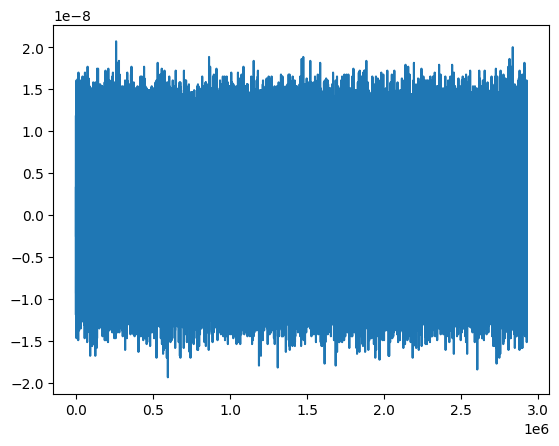

In [40]:
plt.plot(losses_50_200)
plt.show()

In [43]:
%%time
validate_model(all_ids, model=model, train_loader=train_loader, test_loader=val_loader, k=CFG.K)

  0%|          | 0/19506 [00:00<?, ?it/s]

  0%|          | 0/8360 [00:00<?, ?it/s]

NDCG@k	train:	0.00020430740904768673	test:	0.00019011619408802703
MAP@k	train:	0.00011679655013557112	test:	0.00010618476233196575
CPU times: user 43min 9s, sys: 9.39 s, total: 43min 19s
Wall time: 43min 48s


(0.00020430740904768673,
 0.00019011619408802703,
 0.00011679655013557112,
 0.00010618476233196575)

# Saving model

In [ ]:
torch.save(model, CFG.PATH_GDRIVE_MAIN + '/PyTorch_models/LSTM_v1/model_0ep.pt')

In [ ]:
# Model class must be defined somewhere
model = torch.load(CFG.PATH_FOR_MODEL)
model.eval()